# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Модули используемых алгоритмов

### Подключение используемых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
import warnings
m = Mystem() 

### Функции и процедуры

Выделим в отдельный блок используемые функции для удобства чтения блокнота

In [2]:
# Процедура подсчета пропущенных значений
def na_percent():
    all_data = df.reset_index(drop=True)    
    all_data_na = (all_data.isna().sum() / len(all_data))
    all_data_na = all_data_na.drop(
        all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Пропуски': all_data_na.map("{:.1%}".format)})
    display(missing_data)
    print(f'Структура : {all_data.shape}')
    print('Столбцов с NA:',missing_data.shape[0],'из',df.shape[1])

# Шаблонная процедура автоматизации вывода информации о столбцах датафрейма
def col_info(df,col,bins=0):
    dfcor=df.corr()
    max=0
    if col in dfcor.columns:
        cr=dfcor[col] 
        max=cr.loc[cr<1].max()
    print(df[col].describe())
    if bins>0:
        print(df[col].value_counts(bins=bins).head())
    else:
        print(df[col].value_counts().head())
    if df[col].isna().sum()>0:
        print('Пропуски ',df[col].isna().sum())
        if max!=0:
            print('Корреляция по ',cr.loc[cr<1].sort_values(ascending=False).index.to_list()[0],"{:.1%}".format(max))
    else:
        print('Пропусков нет.')
    
# Поиск и замена пропущенных значений датафрейма по коррелируемым признакам   
def filldf(df2):
    def fgrcalc(num):
        for i in range(1,11):
            if (num>=lst[i-1] and num<=lst[i]):
                return i     
    res= pd.DataFrame(columns=['столбец','восстановлено','осталось','по_значениям','корреляция'])
    global lst
    min_cor=0.5
    df3=df2.copy()
    dfcor=df2.corr()
    for col in df2.columns:
        if (df[col].isna().sum()>0) and (col in dfcor.columns):
            na=df[col].isna().sum()
            cr=dfcor[col]
            cr_i=cr.loc[(cr>min_cor) & (cr<1)]
            cr=cr_i.index.sort_values(ascending=False).to_list()
            if len(cr)>0:                
                for i in cr:
                    if i+'_id' not in df3.columns:
                        lst=[0]+[df2[col].sort_values().to_list()[round(df2.shape[0]/10)*i-2] for i in range(1,11)]
                        df3[i+'_id']=df2[col].map(fgrcalc)                
                df2[col]=df2[col].fillna(df3.groupby([i+'_id' for i in cr])[col].transform('median'))
                df2[col]=df2[col].fillna(df3.groupby(cr)[col].transform('median'))
                for i in cr:
                    df2[col]=df2[col].fillna(df3.groupby(i)[col].transform('median'))
                res.loc[len(res.index)]=[col,na-df2[col].isna().sum(),df2[col].isna().sum(),cr,"{:.0%}".format(cr_i.max())]
    print("Значение минимальной корреляции -","{:.0%}".format(min_cor))
    display(res.sort_values(by='корреляция', ascending=False).head(20))

# Метод позволяет определить наименьший тип данных, для ускорения вычислений датафрейма и уменьшения занимаемой памяти
def type_optimize(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    print(df.dtypes)
    
# Поиск неявных дубликатов
def find_duplicates(df,col):
    dc={}
    for i in range(len(df[col].sort_values().unique())):
        type_list=list(df[col].sort_values().unique())
        arg=type_list[i]
        type_list.pop(i)
        wr=list(filter(lambda x: arg in x, type_list))
        if len(wr)>0:
            if arg not in dc.keys():
                dc[arg]=wr
            else:
                dc[arg]+=wr
    for key,value in dc.items():
        dc[key]=sorted(list(set(value)))
        str_val=", ".join(list(map(lambda x: str(x[:x.find(key)]+"\033[31m"+\
                                                x[x.find(key):x.find(key)+len(key)]+\
                                                "\033[0m"+x[x.find(key)+len(key):]),value)))
        print(("{0} --- {1}").format(key,str_val))

# Внесение изменений в строковые значения
def replace_city(df,col,name_):      
    global name_lst
    name_lst=name_
    def repl(name):
        global name_lst
        if name_lst[0] in name:
            return name.replace(name_lst[0], name_lst[1])
        else:
            return name  
    df[col] = df[col].apply(repl)

# Поиск и замена пропущенных значений датафрейма по столбцам расстояний
def filldf_gr(df,id_=100,distance_cols=['airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']):
    global lst,id,df3,df4
    id=id_
    na=df['airports_nearest'].isna().sum()
    
    def fgrcalc(num):
        for i in range(1,11):
            if (num>=lst[i-1] and num<=lst[i]):
                return i  
            
    df4=df.copy()
    df3=df.loc[:,distance_cols].copy()#pd.DataFrame()
    
   
    def fill_similar(row):
        global df3,lst2,col    
        if pd.isna(row[col]):
            try:
                if len(lst2)==3:            
                    row[col]=df3.loc[df3[lst2[0]]==row[lst2[0]],
                                     df3[lst2[1]]==row[lst2[1]],
                                     df3[lst2[2]]==row[lst2[2]]].madian
                elif len(lst2)==2:
                    row[col]=df3.loc[df3[lst2[0]]==row[lst2[0]],
                                     df3[lst2[1]]==row[lst2[1]]].madian
            except:
                pass
        return row      
                        
    def get_cols(lst_):
        lst2=[]   
        global df3,df4,col
        #print(lst_id)
        for col in lst_:
            lst=[]
            for i in range(len(lst_)):
                if i!=lst_.index(col):
                    lst.append(lst_[i])           
            lst2.append(lst)
            #print(col,lst,"\n")
            #df=df.apply(fill_similar, axis=1)
            df[col[:-3]]=df[col[:-3]].fillna(df4.groupby(lst)[col[:-3]].transform('median'))
        if len(lst)>2:
            for col in lst2:
                get_cols(col)
                
    for col in distance_cols:
        lst=[0]+[df[col].sort_values().to_list()[round(df.shape[0]/11)*i-2] for i in range(1,11)]
        df3[col+'_id']=df[col].map(fgrcalc)
        df4[col+'_id']=df3[col+'_id']
        #df3=df3.fillna(0)
  
    get_cols(df3.columns.to_list()[-4:])
    for i in range(4):
        print(distance_cols[i],df[distance_cols[i]].isna().sum())

# Функция построения матрицы диаграмм рассеивания
def matrix(df,cols,km=9):
    df_center=df.loc[df_piter.center_distance<km].loc[:,cols]
    df_full=df.loc[df_piter.center_distance>km].loc[:,cols]
    g=sns.pairplot(pd.concat([df_center.assign(hue='Центр'), 
                            df_full.assign(hue='Город')]), 
                 hue='hue', diag_kind='kde', palette=['red', 'blue'])
    g.fig.set_size_inches(15,15)

## Изучение данных из файла

### Реализация кода

Вывод информации о структуре датафрейма. 

In [3]:
df=pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Также отдельно выведем столбцы с пропущенными значениями в процентном соотношении к общему обьему

In [4]:
na_percent()

,Пропуски
is_apartment,88.3%
parks_nearest,65.9%
ponds_nearest,61.6%
balcony,48.6%
ceiling_height,38.8%
airports_nearest,23.4%
cityCenters_nearest,23.3%
ponds_around3000,23.3%
parks_around3000,23.3%
days_exposition,13.4%


Структура : (23699, 22)
Столбцов с NA: 14 из 22


### Вывод

Датасет состоит из 22 столбцов на 23699 строк. 14 столбцов имеют тип float64, по 3 int64 и object, 2 булевых. 14 столбцов имеют пропуски от 0.2% до 88.3%.

## Предобработка данных

### Определение и изучение пропущенных значений

Проведем оптимизацию типов столбцов по типу данных и выведем результат

In [5]:
type_optimize(df)

total_images               uint8
last_price               float32
total_area               float32
first_day_exposition    category
rooms                      uint8
ceiling_height           float32
floors_total             float32
living_area              float32
floor                      uint8
is_apartment            category
studio                      bool
open_plan                   bool
kitchen_area             float32
balcony                  float32
locality_name           category
airports_nearest         float32
cityCenters_nearest      float32
parks_around3000         float32
parks_nearest            float32
ponds_around3000         float32
ponds_nearest            float32
days_exposition          float32
dtype: object


Заменены int64 на unit8, float64 на float32 всвязи размером используемых значений, object на category, т.к имеет строковый тип данных.

Восстановим все столбцы с высоким показателем корреляции.Для этого используем функцию поиска зависимостей по всему датафрейму. Результат работы функции представлен ниже.

In [6]:
filldf(df)

Значение минимальной корреляции - 50%


,столбец,восстановлено,осталось,по_значениям,корреляция
1,living_area,1903,0,"[total_area, rooms, last_price]",94%
0,floors_total,86,0,[floor],68%
2,kitchen_area,2256,22,"[total_area, last_price]",61%


<b><i>Проверим значения по столбцам</i></b>

Была задумка в ряду однородности получаемой информации связать столбцы df, квартили, min/max, пропуски, корреляцию и прочие значения в отдельный датафрейм. Но всвязи с разнородностью выводов и порядком действий пришлось оставить для каждого столбца по отдельности.

<b>total_images</b>

In [7]:
col_info(df,df.columns[0])

count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64
10    1798
9     1725
20    1694
8     1585
7     1521
Name: total_images, dtype: int64
Пропусков нет.


Не имеет пропусков, значения корректны.

<b>last_price</b> 

In [8]:
col_info(df,df.columns[1]) 

count        23699.0
mean       6541548.5
std       10887013.0
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6800000.0
max      763000000.0
Name: last_price, dtype: float64
4500000.0    342
3500000.0    291
4000000.0    260
4300000.0    260
4200000.0    259
Name: last_price, dtype: int64
Пропусков нет.


<b>total_area</b> 

In [9]:
col_info(df,df.columns[2]) 

count    23699.000000
mean        60.348648
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900002
max        900.000000
Name: total_area, dtype: float64
45.0    419
42.0    383
60.0    347
31.0    346
44.0    345
Name: total_area, dtype: int64
Пропусков нет.


<b>first_day_exposition</b>

In [10]:
display(df['first_day_exposition'].sample())
df['first_day_exposition']=pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT')

6874    2016-02-05T00:00:00
Name: first_day_exposition, dtype: category
Categories (1491, object): [2014-11-27T00:00:00, 2014-11-29T00:00:00, 2014-12-04T00:00:00, 2014-12-05T00:00:00, ..., 2019-04-30T00:00:00, 2019-05-01T00:00:00, 2019-05-02T00:00:00, 2019-05-03T00:00:00]

<b>rooms</b> 

In [11]:
col_info(df,df.columns[4]) 

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
1    8047
2    7940
3    5814
4    1180
5     326
Name: rooms, dtype: int64
Пропусков нет.


<b>ceiling_height</b> 

In [12]:
col_info(df,df.columns[5]) 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
2.5    3515
2.6    1646
2.7    1574
3.0    1112
2.8     993
Name: ceiling_height, dtype: int64
Пропуски  9195
Корреляция по  total_area 9.5%


Максимальная высота потолков 100м, должно быть просторное помещение, такая же еще у северной пирамиды Египта. Слишком низкая корреляция этих значений не позволяет восстановить данные, а замена средним значением почти половины столбца датафрейма приведет к статистически незначимой информации. Исправим возможные опечатки и заменим средним значением выбросы.

In [13]:
df['ceiling_height'].loc[df['ceiling_height'] >= 10].value_counts()

27.0     8
25.0     7
32.0     2
10.3     1
22.6     1
100.0    1
27.5     1
20.0     1
14.0     1
26.0     1
24.0     1
Name: ceiling_height, dtype: int64

In [14]:
df.loc[df['ceiling_height']==100,'ceiling_height'] = df['ceiling_height'].mean()
df.loc[df['ceiling_height']>=20,'ceiling_height'] = df.loc[df['ceiling_height']>=20,'ceiling_height']/10

<b>floors_total</b> 

In [15]:
col_info(df,df.columns[6]) 

count    23699.000000
mean        10.681759
std          6.599383
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
5.0     5807
9.0     3770
16.0    1388
12.0    1362
4.0     1200
Name: floors_total, dtype: int64
Пропусков нет.


Значения корректные. 

<b>living_area</b> 

In [16]:
col_info(df,df.columns[7]) 

count    23699.000000
mean        34.500656
std         21.889153
min          2.000000
25%         18.600000
50%         30.000000
75%         42.400002
max        409.700012
Name: living_area, dtype: float64
18.0    949
17.0    749
30.0    663
16.0    510
20.0    501
Name: living_area, dtype: int64
Пропусков нет.


<b>floor</b>

In [17]:
col_info(df,df.columns[8]) 

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64
2    3368
3    3073
1    2917
4    2804
5    2621
Name: floor, dtype: int64
Пропусков нет.


In [18]:
df['floor'].loc[df['floor'] >= 100].value_counts()

Series([], Name: floor, dtype: int64)

<b>is_apartment</b> 

In [19]:
col_info(df,df.columns[9])

count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object
False    2725
True       50
Name: is_apartment, dtype: int64
Пропуски  20924


Заменим на наиболее частое значение False, чтобы выполнить конвертацию типов и значения не приобразовались на дефолтные, т.е True.

In [20]:
df.loc[df['is_apartment'].isna(),'is_apartment']= False
df['is_apartment']=df['is_apartment'].astype('bool')

<b>studio</b> 

In [21]:
col_info(df,df.columns[10]) 

count     23699
unique        2
top       False
freq      23550
Name: studio, dtype: object
False    23550
True       149
Name: studio, dtype: int64
Пропусков нет.


<b>open_plan</b> 

In [22]:
col_info(df,df.columns[11]) 

count     23699
unique        2
top       False
freq      23632
Name: open_plan, dtype: object
False    23632
True        67
Name: open_plan, dtype: int64
Пропусков нет.


<b>kitchen_area</b> 

In [23]:
col_info(df,df.columns[12]) 

count    23677.000000
mean        10.494967
std          5.759397
min          1.300000
25%          7.100000
50%          9.100000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64
10.0    1621
6.0     1367
8.0     1251
9.0     1235
7.0     1130
Name: kitchen_area, dtype: int64
Пропуски  22
Корреляция по  total_area 61.6%


Заменим оставшиеся пропуска медианой.

In [24]:
df.loc[df['kitchen_area'].isna(),'kitchen_area']=df['kitchen_area'].median()

<b>balcony</b>

In [25]:
col_info(df,df.columns[13]) 

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
Name: balcony, dtype: int64
Пропуски  11519
Корреляция по  floors_total 19.2%


Слишком большая часть пропусков для замены медианой, восстановление также будет с большой погрешностью. Если человек не указал число балконов — скорее всего, их нет. Такие пропуски правильно заменить на 0.

In [26]:
df.loc[df['balcony'].isna(),'balcony']=0

<b>locality_name</b> 

In [27]:
col_info(df,df.columns[14]) 

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object
Санкт-Петербург    15721
посёлок Мурино       522
посёлок Шушары       440
Всеволожск           398
Пушкин               369
Name: locality_name, dtype: int64
Пропуски  49


Т.к столбец имеет строковый тип и их не много, можно удалить пропущенные значения.

In [28]:
df.dropna(subset=['locality_name'], inplace=True)
df.reset_index(drop=True)
df['locality_name'].value_counts()

Санкт-Петербург          15721
посёлок Мурино             522
посёлок Шушары             440
Всеволожск                 398
Пушкин                     369
                         ...  
деревня Хязельки             1
деревня Хапо-Ое              1
деревня Трубников Бор        1
деревня Тойворово            1
поселок Жилгородок           1
Name: locality_name, Length: 364, dtype: int64

Проверим наличие неявных дубликатов

In [29]:
words = ' '.join(df['locality_name'].unique()).split()
display(pd.DataFrame(list(Counter(words).items()),columns=['city', 'cnt']).sort_values('cnt', ascending=False).head(10))

,city,cnt
15,поселок,107
11,деревня,106
1,посёлок,94
17,типа,39
16,городского,39
3,городской,14
59,село,9
19,Бор,8
129,станции,8
33,товарищество,5


In [30]:
find_duplicates(df,'locality_name')

Высоцк --- село Русско-Высоцкое
Кингисепп --- поселок Кингисеппский
Коммунар --- поселок Коммунары
Кудрово --- деревня Кудрово
Луга --- поселок Усть-Луга, посёлок Усть-Луга
Любань --- поселок Любань
Мурино --- поселок Мурино, посёлок Мурино
Никольское --- село Никольское
деревня Бор --- деревня Борисова Грива
деревня Старая --- деревня Старая Пустошь


Деревня со временем получает статус города и название может измениться. На основе выявленных дубликатов исправим имена населенных пунктов:
1. изменения в статусе поселок -> город
2. пос<font color='red'>е</font>лок -> пос<font color='red'>ё</font>лок
3. поселок городского типа -> городской поселок
4. коттеджный поселок -> поселок
5. село -> деревня

In [31]:
replace_city(df,'locality_name',['поселок','посёлок'])
replace_city(df,'locality_name',['городской посёлок','посёлок городского типа'])
replace_city(df,'locality_name',['коттеджный посёлок','посёлок'])
replace_city(df,'locality_name',['село','деревня'])
replace_city(df,'locality_name',['деревня Кудрово','Кудрово'])
replace_city(df,'locality_name',['деревня Никольское','Никольское'])
replace_city(df,'locality_name',['посёлок Любань','Любань'])
replace_city(df,'locality_name',['посёлок Усть-Луга','посёлок Усть-Луга'])
replace_city(df,'locality_name',['посёлок Мурино','Мурино'])

Далее airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest - расстояния до ближайших объектов могут коррелировать по совокупности значений. Гипотеза - обьекты недвижимости находящиеся в одной территориальной зоне могут обьединяться в дома, дома в кварталы, кварталы в районы, следовательно показатели удаленности у них будут одинаковые или по крайней мере отличаться не значительно. Имея N-1 одинаковых параметров удаленности у подмножества обьектов df можно утверждать, что пропущенный параметр N с большой долей вероятности будет равен такому же значению подмножества df. 

Решение данной задачи возможно 3 способами:
1. Кластеризацией схожих параметров
2. Распределение параметров на зоны(массивы) с максимальным возможным отклонением R и далее минимизация R через целевую функцию генетического алгоритма.
3. Категоризация параметров уделенности и восстановление пропусков по схожим категориям. 

Проверим гипотезу по 3, менее трудоемкому варианту. Изучим сначала параметры удаленности обьектов:


<b>airports_nearest</b> 

In [32]:
col_info(df,df.columns[15]) 

count    18116.000000
mean     28803.224609
std      12637.314453
min          0.000000
25%      18575.750000
50%      26756.500000
75%      37294.000000
max      84869.000000
Name: airports_nearest, dtype: float64
37434.0    61
21928.0    32
44870.0    30
39946.0    30
18732.0    27
Name: airports_nearest, dtype: int64
Пропуски  5534
Корреляция по  cityCenters_nearest 27.2%


Пропуски занимают четверть всех значений, довольно существенно для удаления. 

<b>cityCenters_nearest</b>

In [33]:
col_info(df,df.columns[16]) 

count    18139.000000
mean     14197.860352
std       8606.830078
min        181.000000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
8460.0     61
20802.0    32
10720.0    30
8434.0     27
20444.0    27
Name: cityCenters_nearest, dtype: int64
Пропуски  5511
Корреляция по  airports_nearest 27.2%


Структура значений идентичная как и у airports_nearest

<b>parks_around3000</b> 

In [34]:
col_info(df,df.columns[17]) 

count    18140.000000
mean         0.611577
std          0.802003
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64
0.0    10080
1.0     5671
2.0     1744
3.0      645
Name: parks_around3000, dtype: int64
Пропуски  5510
Корреляция по  ponds_around3000 30.5%


<b>parks_nearest</b> 

In [35]:
col_info(df,df.columns[18]) 

count    8064.000000
mean      490.830719
std       342.554382
min         1.000000
25%       288.000000
50%       454.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64
441.0    67
173.0    41
392.0    41
456.0    40
471.0    32
Name: parks_nearest, dtype: int64
Пропуски  15586
Корреляция по  floors_total 9.7%


<b>ponds_around3000</b>

In [36]:
col_info(df,df.columns[19]) 

count    18140.000000
mean         0.769680
std          0.937948
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64
0.0    9055
1.0    5702
2.0    1889
3.0    1494
Name: ponds_around3000, dtype: int64
Пропуски  5510
Корреляция по  parks_around3000 30.5%


<b>ponds_nearest</b> 

In [37]:
col_info(df,df.columns[20]) 

count    9085.000000
mean      518.059875
std       277.841736
min        13.000000
25%       293.000000
50%       502.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64
427.0    70
454.0    41
153.0    40
433.0    39
564.0    37
Name: ponds_nearest, dtype: int64
Пропуски  14565
Корреляция по  floors_total 4.0%


Пропустим датафрейм через функцию категоризации и посмортим какие параметры удалось восстановить(значение/пропуски):

In [38]:
filldf_gr(df)

airports_nearest 5521
cityCenters_nearest 5510
parks_nearest 6211
ponds_nearest 6175


ponds_nearest - почти 8 тысяч значений были восстановлены при наличии 2-3 категорий параметров удаленности. Остальные параметры не имеют достаточно значений по которым возможно провести ассоциации по категориям. 

<b>days_exposition</b>

In [39]:
col_info(df,df.columns[21]) 

count    20470.000000
mean       180.753204
std        219.777924
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
45.0    879
60.0    538
7.0     234
30.0    208
90.0    203
Name: days_exposition, dtype: int64
Пропуски  3180
Корреляция по  total_area 15.0%


Поиск дубликатов

In [40]:
df.loc[df.duplicated()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


### Приведение данных к нужным типам

Всвязи с проведенными изменениями выполним еще раз оптимизацию типов

In [41]:
type_optimize(df)

total_images                     uint8
last_price                     float32
total_area                     float32
first_day_exposition    datetime64[ns]
rooms                            uint8
ceiling_height                 float32
floors_total                   float32
living_area                    float32
floor                            uint8
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float32
balcony                        float32
locality_name                 category
airports_nearest               float32
cityCenters_nearest            float32
parks_around3000               float32
parks_nearest                  float32
ponds_around3000               float32
ponds_nearest                  float32
days_exposition                float32
dtype: object


### Вывод

1. Заменены пропуски по коррелируемым значениям столбцов
2. Выявлены и исправлены неявные дубликаты
3. Скорректированы типы столбцов
4. Явные дубликаты строк отсутствуют

## Расчёты и добавление результатов в таблицу

### Цена квадратного метра

In [42]:
df['price_m2']=(df.last_price//df.total_area).astype(int)
df[['last_price','total_area','price_m2']].head()

,last_price,total_area,price_m2
0,13000000.0,108.000000,120370
1,3350000.0,40.400002,82920
2,5196000.0,56.000000,92785
3,64900000.0,159.000000,408176
4,10000000.0,100.000000,100000


### День недели, месяц и год публикации объявления

In [43]:
df['pub_d'] = df.first_day_exposition.dt.weekday
df['pub_m'] = df.first_day_exposition.dt.month
df['pub_y'] = df.first_day_exposition.dt.year
df[['pub_d','pub_m','pub_y']].head()

,pub_d,pub_m,pub_y
0,3,3,2019
1,1,12,2018
2,3,8,2015
3,4,7,2015
4,1,6,2018


### Этаж квартиры; варианты — первый, последний, другой

In [44]:
df['floor_class']=df['floor']
df.loc[df.floor_class==1,'floor_class']='первый'
df.loc[df.floor_class==df.floors_total,'floor_class']='последний'
df.loc[(df.floor_class!='первый') & (df.floor_class!='последний'),'floor_class']='другой'
df.floor_class.unique()

array(['другой', 'первый', 'последний'], dtype=object)

### Соотношение жилой и общей площади, а также отношение площади кухни к общей

In [45]:
df['area_ratio'] = df.living_area/df.total_area
df['kitchen_ratio'] = df.kitchen_area/df.total_area
df[['total_area','area_ratio','living_area','kitchen_ratio','kitchen_area']].head()

,total_area,area_ratio,living_area,kitchen_ratio,kitchen_area
0,108.000000,0.472222,51.000000,0.231481,25.0
1,40.400002,0.460396,18.600000,0.272277,11.0
2,56.000000,0.612500,34.299999,0.148214,8.3
3,159.000000,0.597484,95.000000,0.094340,15.0
4,100.000000,0.320000,32.000000,0.410000,41.0


### Вывод

1. Добавлена цена квадратного метра по всем обьектам недвижимости
2. Разграничены день недели, месяц и год публикации объявления
3. Добавлены категории по этажам квартиры
4. Вычеслены соотношение жилой и общей площади, соотношение площади кухни к общей

## Исследовательский анализ данных

### Площадь, цена, число комнат, высота потолков

<b>Площадь</b>

count    23650.000000
mean        60.329071
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.699997
max        900.000000
Name: total_area, dtype: float64
(11.111, 189.6]    23385
(189.6, 367.2]       231
(367.2, 544.8]        29
(544.8, 722.4]         4
(722.4, 900.0]         1
Name: total_area, dtype: int64
Пропусков нет.


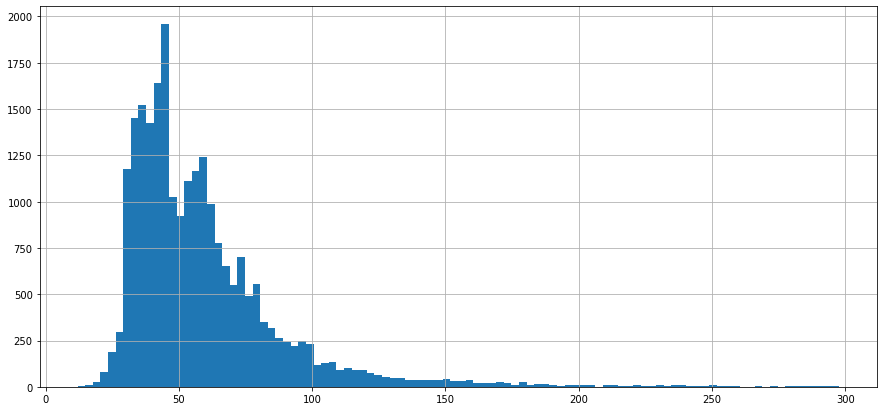

In [46]:
col_info(df,'total_area',bins=5)
df.total_area.loc[df.total_area<300].hist(bins=100,figsize=(15,7))

Изучив гистограмму распределения частоты по площади, можно увидеть признаки вероятностного распределения дискретного типа - распределение Пауссона.

Рассмотрим более детально просадки и скачки на гистограмме увеличив число корзин в 5 раз. 

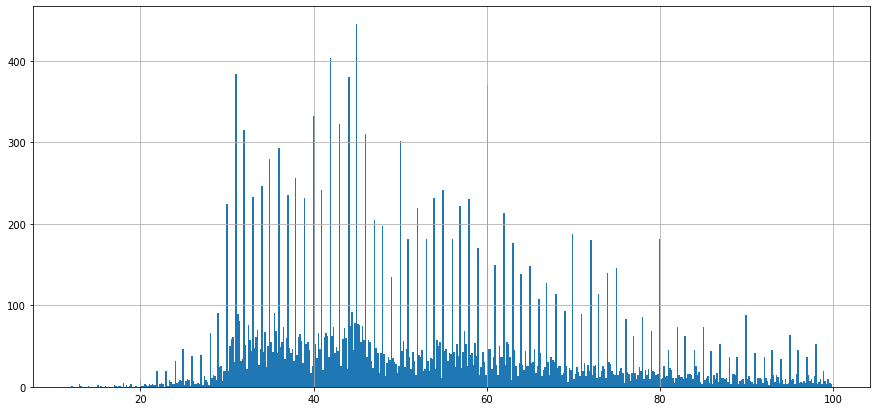

In [47]:
df.total_area.loc[df.total_area<100].hist(bins=500,figsize=(15,7))

 Можно заметить неравномерные перепады по частоте. Обьяснение этому может быть два варианта:
 1. Выбросы
 2. Популярная планировка квартир среди наиболее часто используемых серий(типов) домов застройщиками.

Выведем эти значения

In [48]:
df.total_area.value_counts().head(10)

45.0    419
42.0    383
31.0    346
60.0    346
44.0    343
40.0    315
43.0    300
32.0    289
46.0    282
36.0    280
Name: total_area, dtype: int64

Общая площадь 45м действительно может являться наиболее популярной, поэтому второй вариант по планировкам квартир более актуален.

<b>Цена</b>

count        23650.0
mean       6541126.5
std       10896399.0
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6799000.0
max      763000000.0
Name: last_price, dtype: float64
(-750797.8110000001, 152609752.0]    23635
(152609752.0, 305207314.0]              11
(305207314.0, 457804876.0]               3
(610402438.0, 763000000.0]               1
(457804876.0, 610402438.0]               0
Name: last_price, dtype: int64
Пропусков нет.


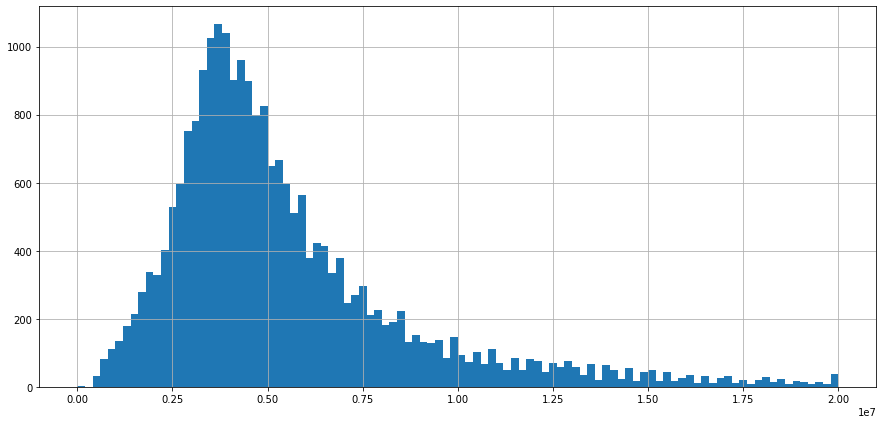

In [49]:
col_info(df,'last_price',bins=5)
df.last_price.hist(bins=100, range=(0,20000000),figsize=(15,7))

Также присутствую отклонения, которые заметны и без детального рассмотрения гистограммы. Изучим эти значения.

In [50]:
df.last_price.value_counts().head(10)

4500000.0    342
3500000.0    289
4000000.0    260
4300000.0    260
4200000.0    258
3600000.0    257
3300000.0    244
3800000.0    240
3200000.0    238
3700000.0    233
Name: last_price, dtype: int64

Обьснение этому является как видно выше притягивание цены не к квадратному метру, а к округлению стоимости недвижимости, поэтому округленные ценники и создают неоднородность на гистограмме.

<b>Число комнат</b>

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
1    8036
2    7924
3    5797
4    1175
5     326
Name: rooms, dtype: int64
Пропусков нет.


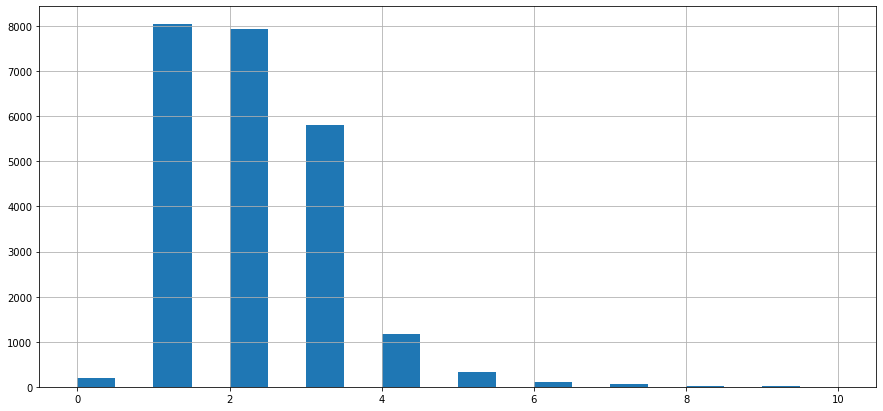

In [51]:
col_info(df,'rooms')
df.rooms.hist(bins=20, range=(0,10),figsize=(15,7))

Выделяется недвижимость без комнат и с более чем 10. Посмотрим эти предложения.

In [52]:
display(df.loc[df.rooms>9].sample(2))
df.loc[df.rooms==0].sample(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m2,pub_d,pub_m,pub_y,floor_class,area_ratio,kitchen_ratio
866,5,25000000.0,363.000000,2017-12-23,14,3.16,5.0,222.000000,4,False,...,2.0,435.0,418.0,68870,5,12,2017,другой,0.611570,0.045730
4149,6,23000000.0,272.600006,2018-01-11,10,3.14,7.0,145.899994,7,False,...,1.0,531.0,NaN,84372,3,1,2018,последний,0.535216,0.068966


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m2,pub_d,pub_m,pub_y,floor_class,area_ratio,kitchen_ratio
10416,8,3700000.0,29.1,2018-08-28,0,2.6,14.0,20.5,2,False,...,0.0,735.0,37.0,127147,1,8,2018,другой,0.704467,0.343643
7003,7,3200000.0,28.0,2015-08-25,0,NaN,23.0,19.0,3,False,...,1.0,233.0,NaN,114285,1,8,2015,другой,0.678571,0.357143


Цена за большое количество комнат подходит под эти значения. А отсутствие комнат можно обьяснить предложением доли в недвижимости, квартиры студии или с особо выгодным расположением под коммерцию.

<b>Высота потолков</b> 

count    14490.000000
mean         2.728857
std          0.313933
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64
2.5    3522
2.6    1646
2.7    1580
3.0    1109
2.8     993
Name: ceiling_height, dtype: int64
Пропуски  9160
Корреляция по  total_area 42.5%


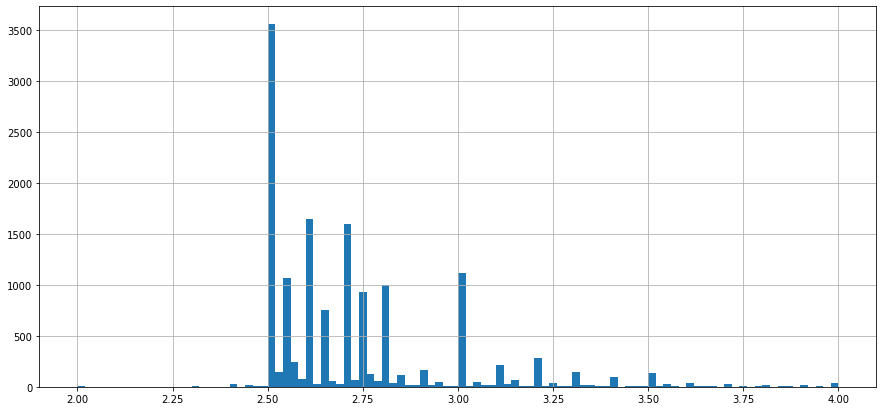

In [53]:
col_info(df,'ceiling_height')
df.ceiling_height.hist(bins=100, range=(2,4),figsize=(15,7))

Неоднорость гистограммы также во многом зависит от строительных стандартов. Наиболее популярные - 2.5, 2.6, 2.7, 3, 3.5, 4. Но все же присутствуют значения выделяющиеся от большинства - <2 и >5. 

Возможно следующее обьяснение:
1. Выбросы, опечатка
2. Редкий формат - подвальное или складское.

<b>Время продажи квартиры</b>

count    20470.000000
mean       180.753204
std        219.777924
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
45.0    879
60.0    538
7.0     234
30.0    208
90.0    203
Name: days_exposition, dtype: int64
Пропуски  3180
Корреляция по  total_area 15.0%


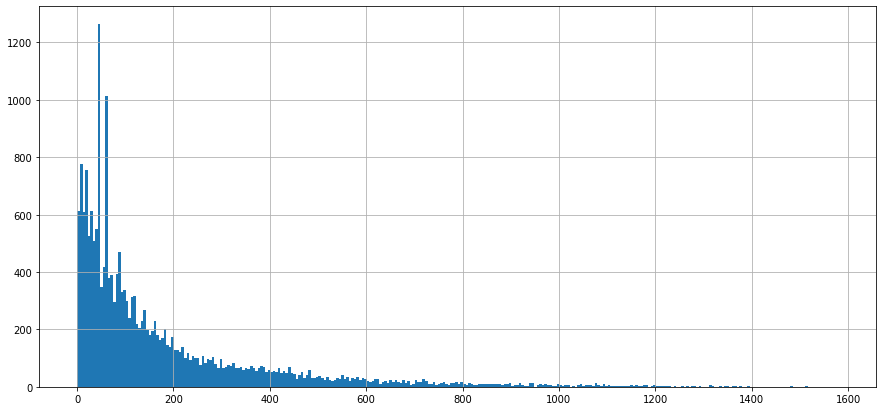

In [54]:
col_info(df,'days_exposition')
df.days_exposition.hist(bins=300,figsize=(15,7))

Cреднее значение больше медианы, т.е. распределение положительно искажено. 

Значение сильно привязано к временным периодам - неделя, месяц, полтора, два и три месяца. Возможно это связано с технлогией продаж или со сроком действия платного обьявления.

Также можно заметить, что время продажи немного коррелирует с общей площадью, что неудевительно, т.к. найти клиента на очень большую площадь всегда сложнее.

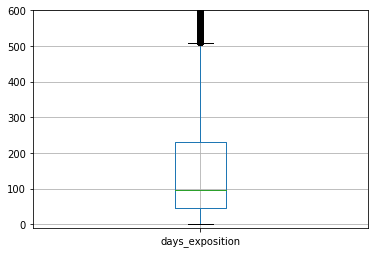

In [55]:
plt.ylim(-10,600)
df.boxplot(column='days_exposition',figsize=(7,7))

In [56]:
print(df['days_exposition'].quantile(0.25))
print(df['days_exposition'].quantile(0.5))
print(df['days_exposition'].quantile(0.75))

45.0
95.0
231.0


Предположим, что быстрая продажа соответствует значению до 45 дней(Q1), а долгая - до 231 дня(Q3).

В среднем обьект недвижимости продается за 95 дней.

<b>Редкие и выбивающиеся значения</b>

Определенная часть выбросов по столбцам была рассмотрена выше. Рассмотрим оставшиеся:

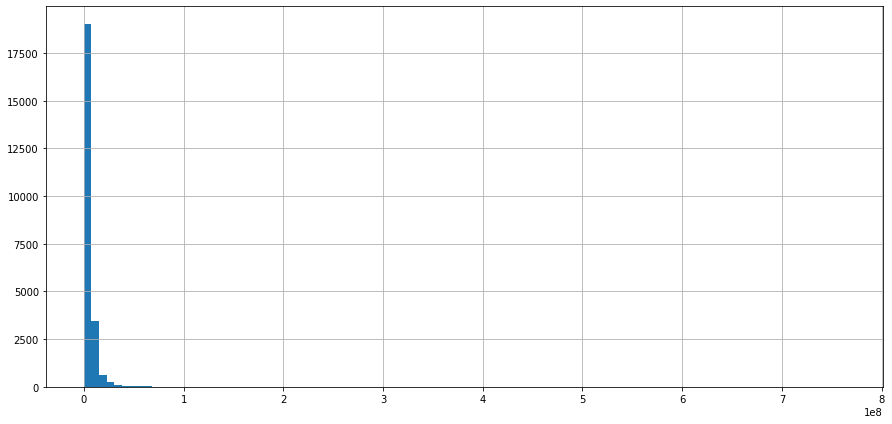

In [57]:
df['last_price'].hist(bins=100,figsize=(15,7))

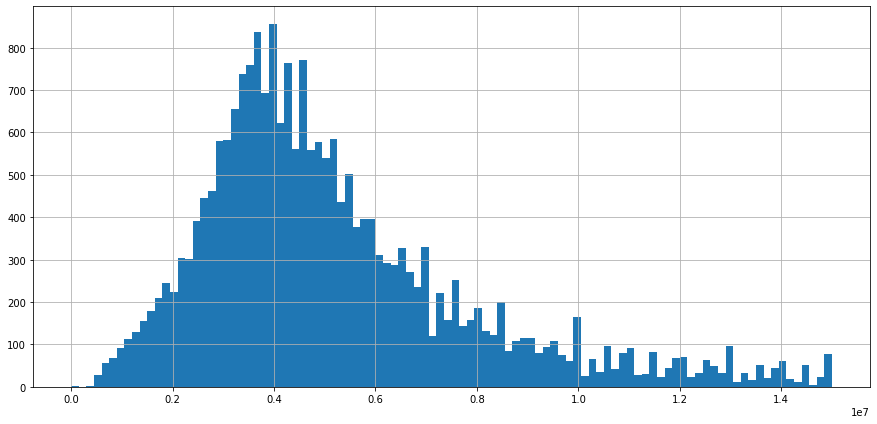

In [58]:
df['last_price'].hist(bins=100, range=(0,15000000),figsize=(15,7))

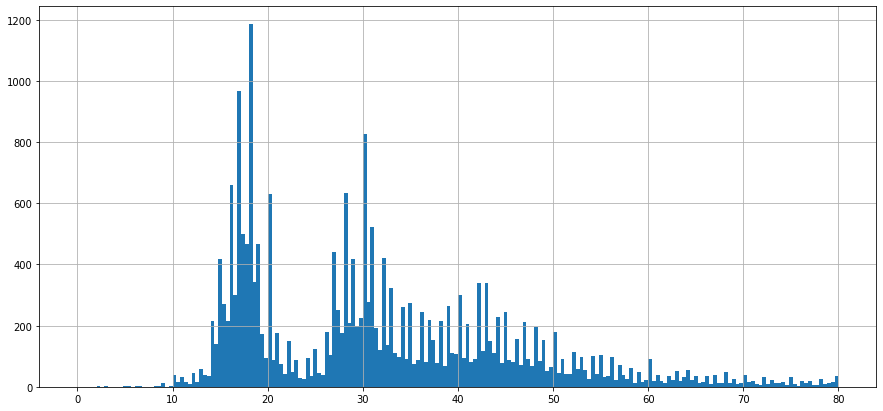

In [59]:
df['living_area'].hist(bins=200, range=(0,80),figsize=(15,7))

Жилая площадь коррелирует с total_area и зависит от популярности планировки.

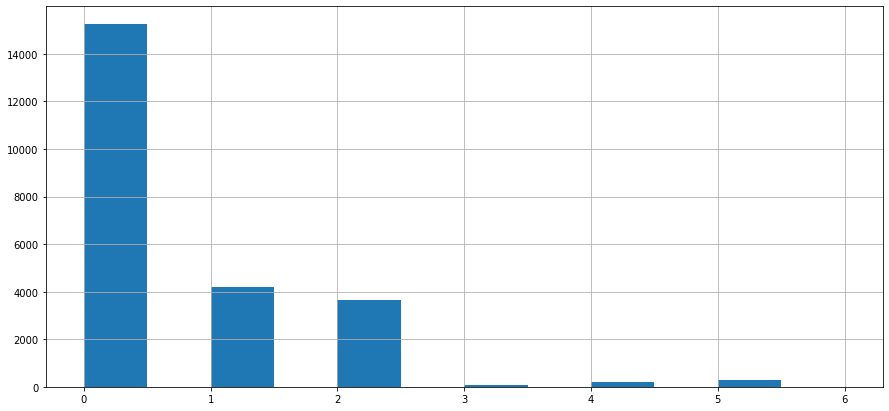

In [60]:
df['balcony'].hist(bins=12, range=(0,6),figsize=(15,7))

<b>Влияние факторов на стоимость квартиры</b>

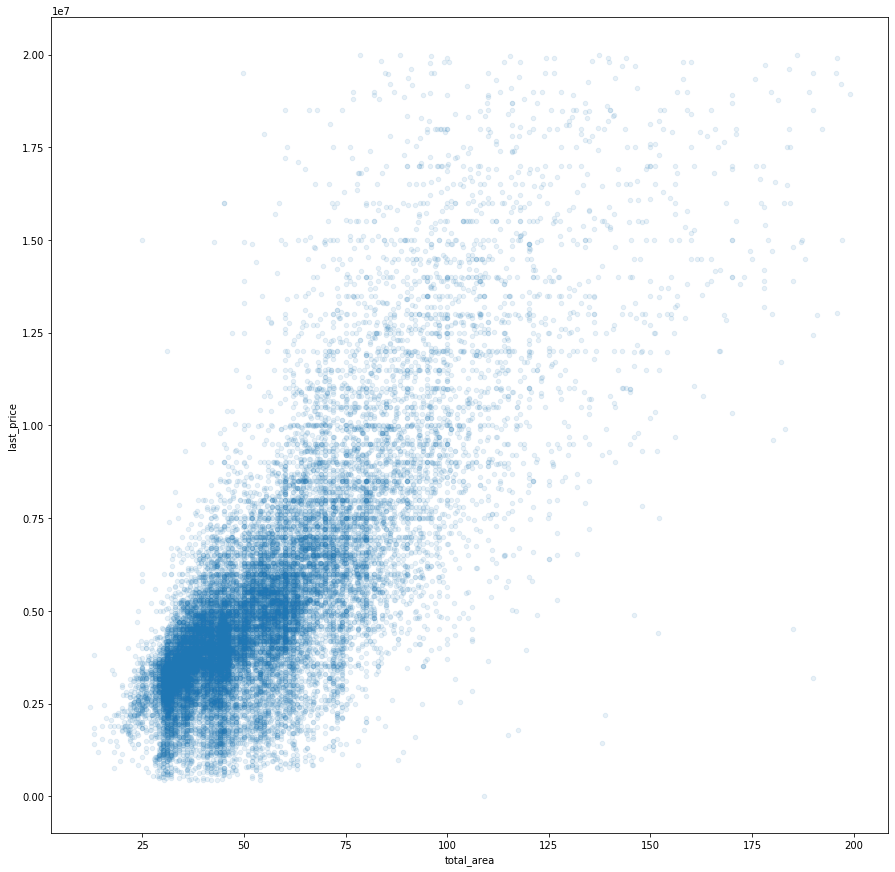

In [61]:
df[(df.total_area<200) & (df.last_price<20000000)].plot(x='total_area', y='last_price', kind='scatter', 
                                                        alpha=0.1, figsize=(15,15))

Прямая корреляция цены по площади.

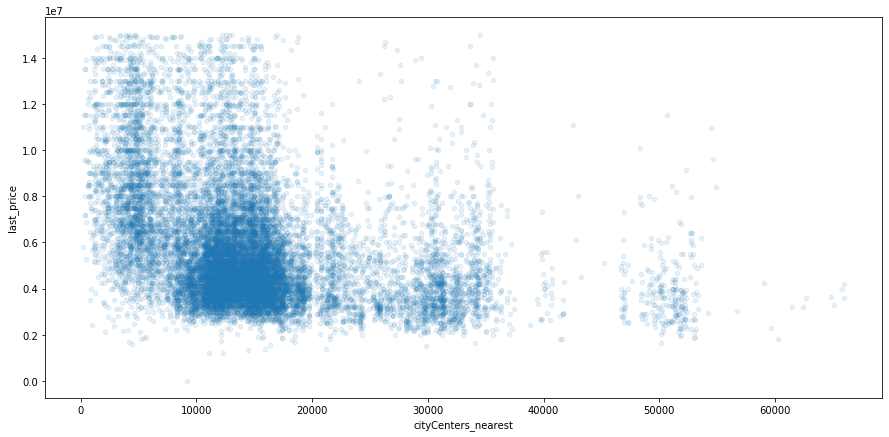

In [62]:
df[df.last_price<15000000].plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.1, figsize=(15,7))

Удаленность от центра оказывает негативное влияние на стоимость, но все же даже при большой удаленности остаются обьекты недвижимости с большой ценой.

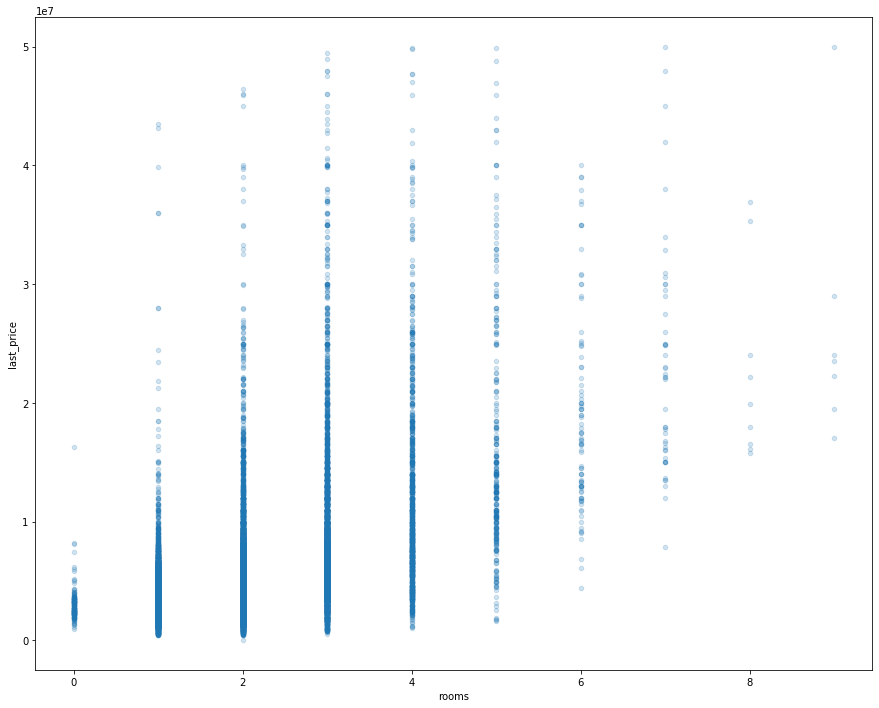

In [63]:
df[(df.last_price<50000000) & (df.rooms<10)].plot(x='rooms', y='last_price', kind='scatter', alpha=0.2, figsize=(15,12))

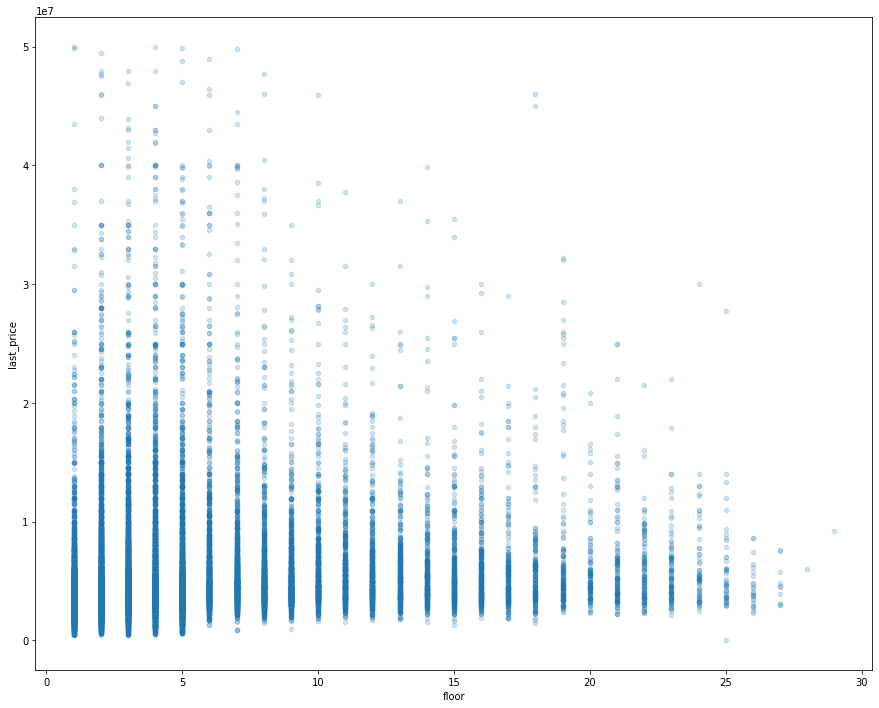

In [64]:
df[(df.last_price<50000000) & (df.floor<30)].plot(x='floor', y='last_price', kind='scatter', alpha=0.2, figsize=(15,12))

А вот с этажами наблюдается обратная корреляция - максимальная цена падает при увеличении этажа, а минимальная незначительно увеличивается.

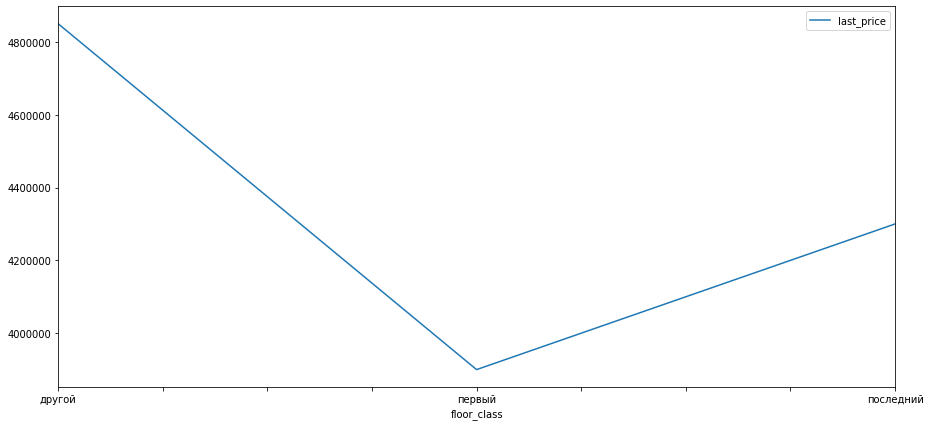

In [65]:
df.pivot_table(index='floor_class',values='last_price', aggfunc='median').plot(figsize=(15,7))

Этот графике говорит про отношение покупателя к этажу: "Все что угодно, только не первый!"

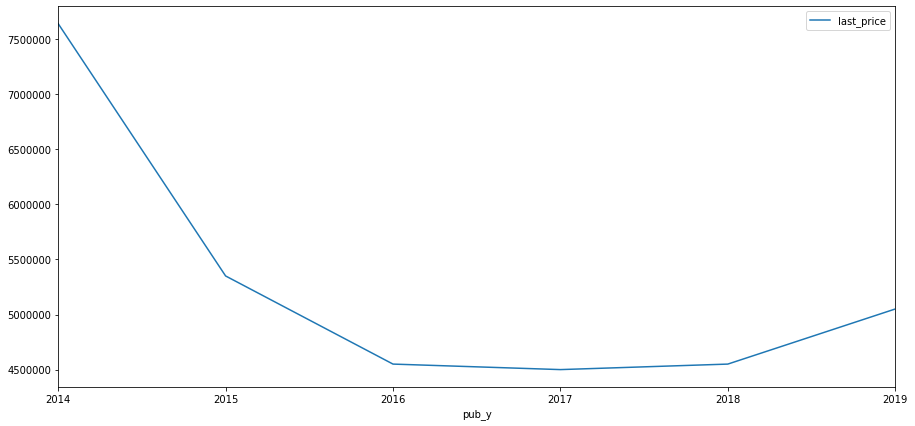

In [66]:
df.pivot_table(index='pub_y',values='last_price', aggfunc='median').plot(figsize=(15,7))

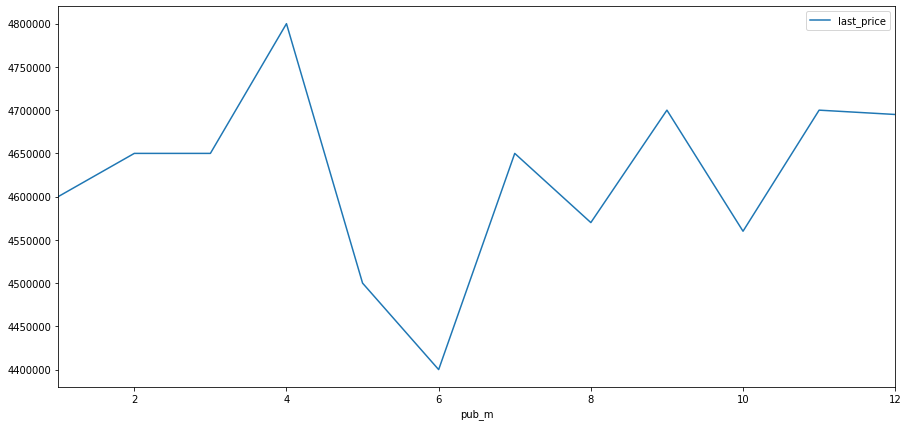

In [67]:
df.pivot_table(index='pub_m',values='last_price', aggfunc='median').plot(figsize=(15,7))

С апреля по июнь наблюдается снижение числа публикаций. Возможно на это оказывыает влияние летний период отпусков.

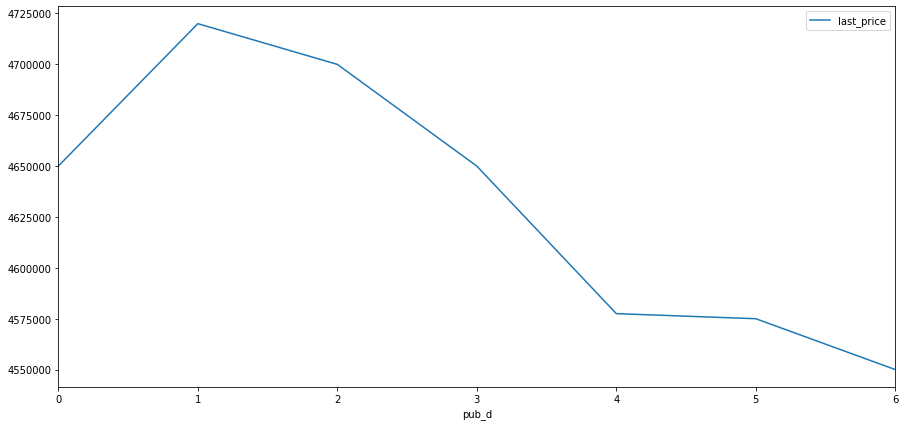

In [68]:
df.pivot_table(index='pub_d',values='last_price', aggfunc='median').plot(figsize=(15,7))

In [69]:
cr=df[['last_price','living_area','rooms','cityCenters_nearest','cityCenters_nearest','floor_class','pub_y','pub_m',
    'pub_d']].corr()['last_price']
cr.loc[(cr<1)].sort_values(ascending=False)

living_area            0.566418
rooms                  0.363421
pub_m                  0.002741
pub_d                  0.001607
pub_y                 -0.042927
cityCenters_nearest   -0.206885
cityCenters_nearest   -0.206885
Name: last_price, dtype: float64

Больше всего влияет на стоимость квартиры общая площадь, меньше всего день недели публикации обьявления.

Рассмотрим 10 населённых пунктов с наибольшим числом объявлений. 

In [70]:
df.pivot_table(index='locality_name', values='price_m2',aggfunc=['count','mean'])\
    .sort_values([('count','price_m2')],ascending=False).head(10)

,count,mean
,price_m2,price_m2
locality_name,,
Санкт-Петербург,15721,114848.559697
Мурино,590,86087.049153
Кудрово,472,95324.463983
посёлок Шушары,440,78676.900000
Всеволожск,398,68654.007538
Пушкин,369,103125.373984
Колпино,338,75424.153846
посёлок Парголово,327,90175.486239


Населённые пункты с самой высокой и низкой стоимостью жилья - Санкт-Петербург и Выборг.

<b>Изучение предложения квартир</b>

In [71]:
df['center_distance'] = df['cityCenters_nearest']//1000
df_piter=df.loc[df.locality_name == "Санкт-Петербург"]
df_piter.pivot_table(index='center_distance', values='price_m2')

,price_m2
center_distance,
0.0,187323.662791
1.0,166603.312500
2.0,146662.420195
3.0,129415.889734
4.0,137475.035281
5.0,146978.777633
6.0,152277.427660
7.0,141399.285012
8.0,120580.911940


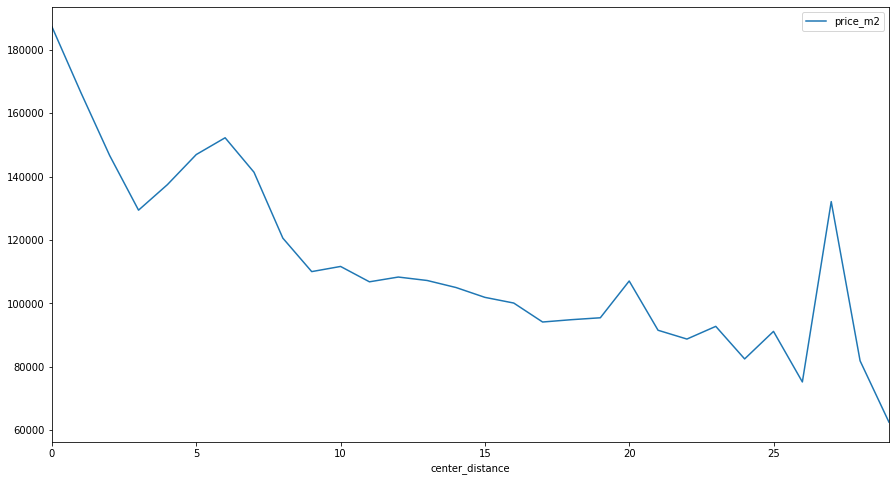

In [72]:
df_piter.pivot_table(index='center_distance', values='price_m2').plot(figsize=(15,8))

Выделяется сильное изменение цены при расстоянии до центра менее 9 км.

<b>Cегмент квартир в центре</b>

Построим матрицу зависимости цены по площади, числе комнат, высоте потолков

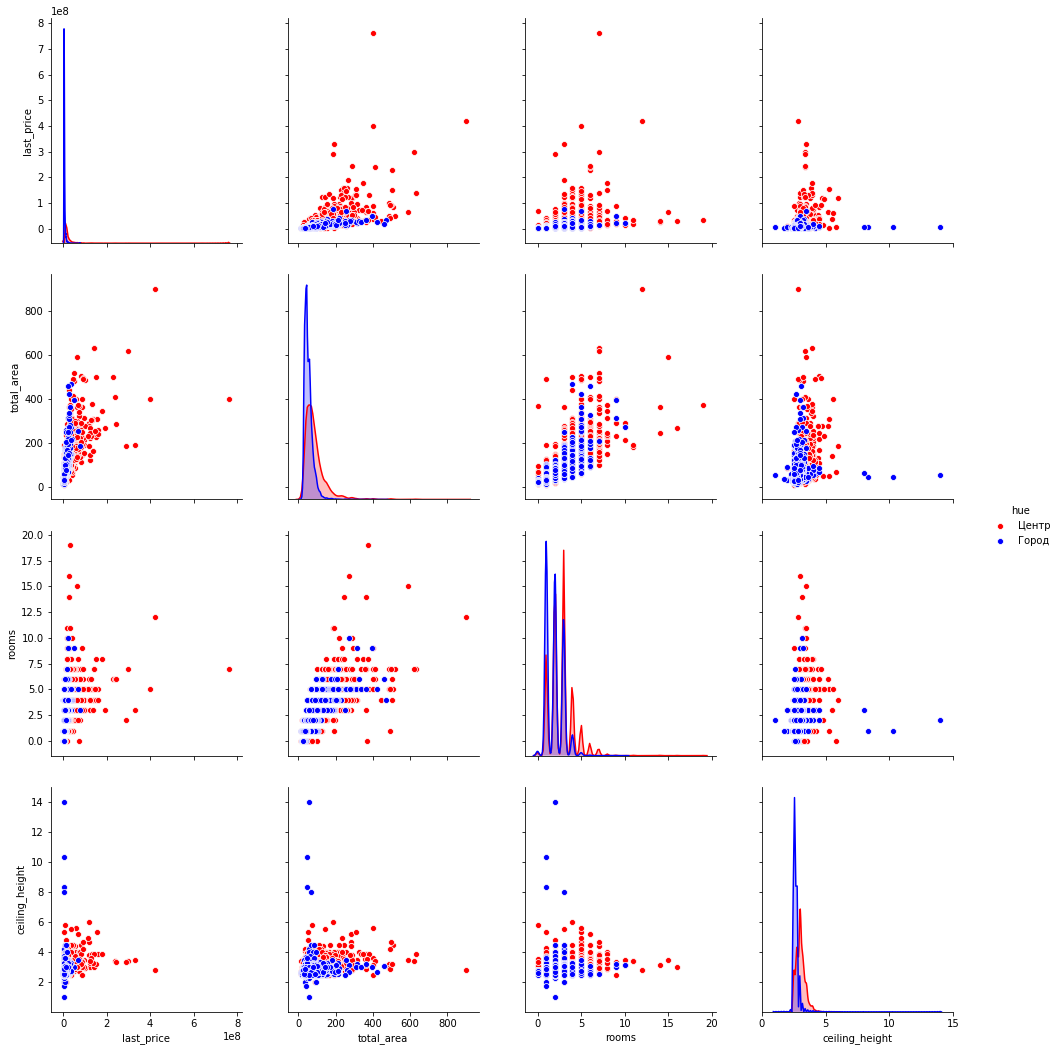

In [73]:
matrix(df_piter,['last_price','total_area', 'rooms', 'ceiling_height'])

Матрица зависимости цены по этажу, удалённости от центра, дате размещения объявления

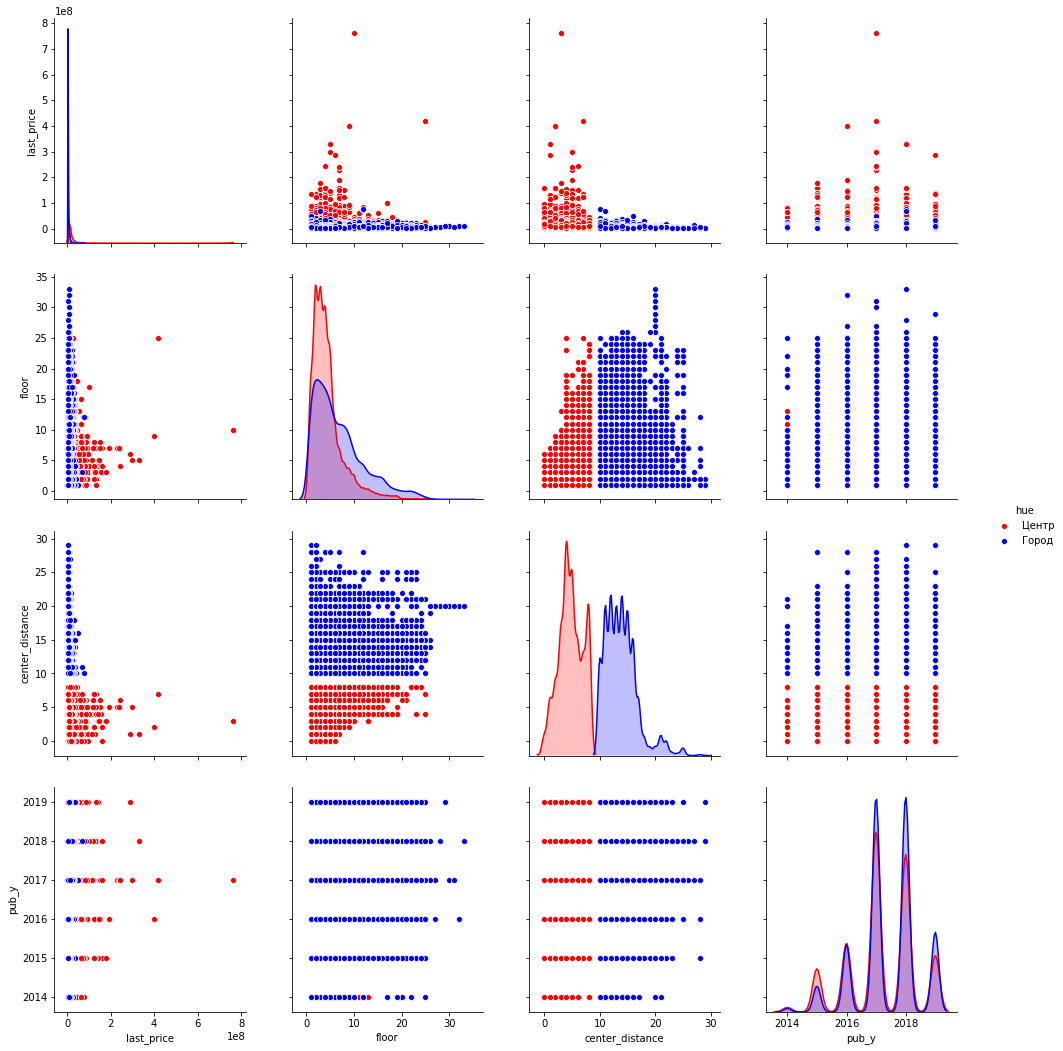

In [74]:
matrix(df_piter,['last_price','floor', 'center_distance','pub_y'])

Как можно заметить цена обьектов недвижимости в центре намного дороже и сильно выделяется по всем сравниваемым параметрам. Для всего города характерны более плавное изменение цены, для центра же более скачкообразное изменение, схожее с выбросами. Основными факторами влияющими на цену являются количество комнат(или площадь) и расстояние от центра. Причем недвижимость в центре имеет более сильную зависимость цены от этих параметров.

## Общий вывод

Стоимость обетов недвижимости имеет зависимость от ряда ее параметров. К ключевым можно отнести площадь, количество комнат и расстояние до центра. В проведенном анализе для города Санкт-Петербург ключевыми параметрами также остаются количество комнат и расстояние от цента. Причем на цены обьектов недвижимости в центре города эти параметры оказывают более сильное влияние.